Available sheets: ['Contents - 3rd release', 'Population', 'Providers and Services', 'Client Summary', 'Expenditure Summary', 'Assessments and approvals', 'Home Care', 'Residential Care', 'Transition Care', 'Home Support', 'Short Term Restorative Care']
R-squared value: 0.9922

Cleaned and Feature-Engineered Dataset:

     Residential_Care_Clients  Home_Care_Clients  Total_Elderly  \
NSW                   59298.0            83768.0   8.673867e+06   
Vic                   47677.0            66674.0   7.183220e+06   
Qld                   37701.0            53631.0   5.449923e+06   
WA                    17207.0            21827.0   2.765994e+06   
SA                    15909.0            22889.0   1.799773e+06   
Tas                    4459.0             6115.0   5.471050e+05   
ACT                    2386.0             2396.0   4.640830e+05   
NT                      490.0             1074.0   2.632240e+05   

     Total_Care_Clients  Care_Supply_Ratio    Target  Elderly_Population  \


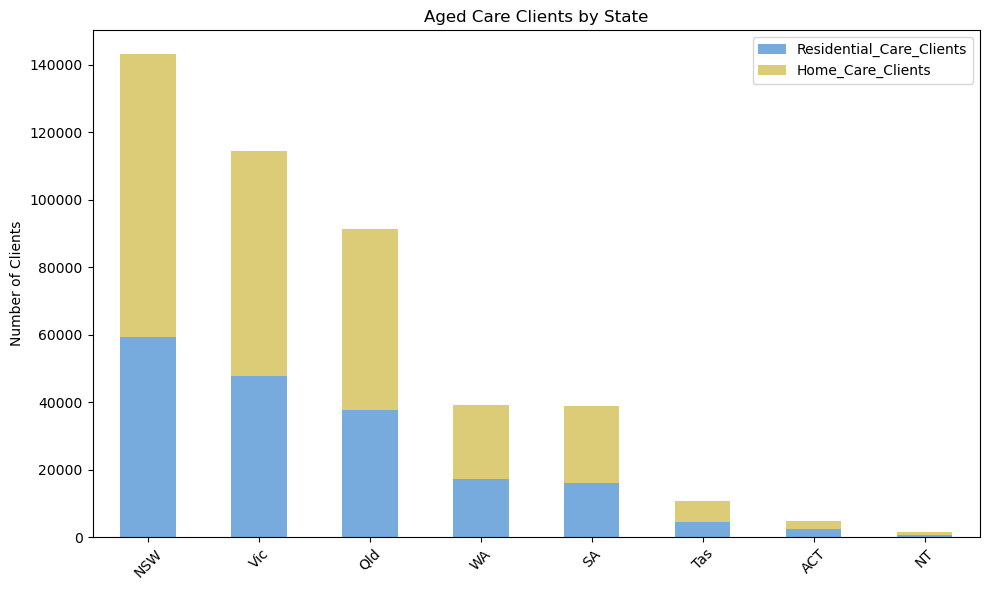

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings("ignore")

# Load the Excel file
xlsx = pd.ExcelFile('Aged-Care-Data-Snapshot-2023-Release-3.xlsx')
print("Available sheets:", xlsx.sheet_names)

# Parse sheets
home_df = xlsx.parse('Home Care', skiprows=6)
res_df = xlsx.parse('Residential Care', skiprows=6)
pop_df = xlsx.parse('Population', skiprows=6)

# Extract and clean relevant data
home_clients = home_df.iloc[3, 1:10].astype(float)
res_clients = res_df.iloc[4, 1:10].astype(float)
female_pop = pop_df.iloc[3, 1:10].astype(float)
male_pop = pop_df.iloc[4, 1:10].astype(float)
total_elderly = female_pop + male_pop

# Index with state names
states = ['NSW', 'Vic', 'Qld', 'WA', 'SA', 'Tas', 'ACT', 'NT', 'Aust']
home_clients.index = states
res_clients.index = states
total_elderly.index = states

# Remove 'Aust' as it's a national aggregate
home_clients = home_clients.drop('Aust')
res_clients = res_clients.drop('Aust')
total_elderly = total_elderly.drop('Aust')

# Build DataFrame
df = pd.DataFrame({
    'Residential_Care_Clients': res_clients,
    'Home_Care_Clients': home_clients,
    'Total_Elderly': total_elderly
})

# Feature engineering
df['Total_Care_Clients'] = df['Residential_Care_Clients'] + df['Home_Care_Clients']
df['Care_Supply_Ratio'] = df['Total_Care_Clients'] / df['Total_Elderly'] * 1000

# Define response and predictor
df['Target'] = df['Total_Care_Clients']  # Response variable
df['Elderly_Population'] = df['Total_Elderly']  # Predictor variable

# Clustering
X_cluster = df[['Total_Elderly', 'Care_Supply_Ratio']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

# Linear regression
model = LinearRegression()
model.fit(df[['Elderly_Population']], df['Target'])
df['Predicted_Care'] = model.predict(df[['Elderly_Population']])

# R-squared score
r2 = r2_score(df['Target'], df['Predicted_Care'])
print(f"R-squared value: {r2:.4f}")  # Optional for report: \textbf{R² = 0.9922}

# Print final cleaned and engineered dataset
print("\nCleaned and Feature-Engineered Dataset:\n")
print(df)

# OPTIONAL: Placeholder for dummy encoding (if needed for modelling)
# df = pd.get_dummies(df, columns=['Cluster'], drop_first=True)

# Plot 1: Stacked Bar Chart
df[['Residential_Care_Clients', 'Home_Care_Clients']].plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#77AADD', '#DDCC77'])
plt.title('Aged Care Clients by State')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

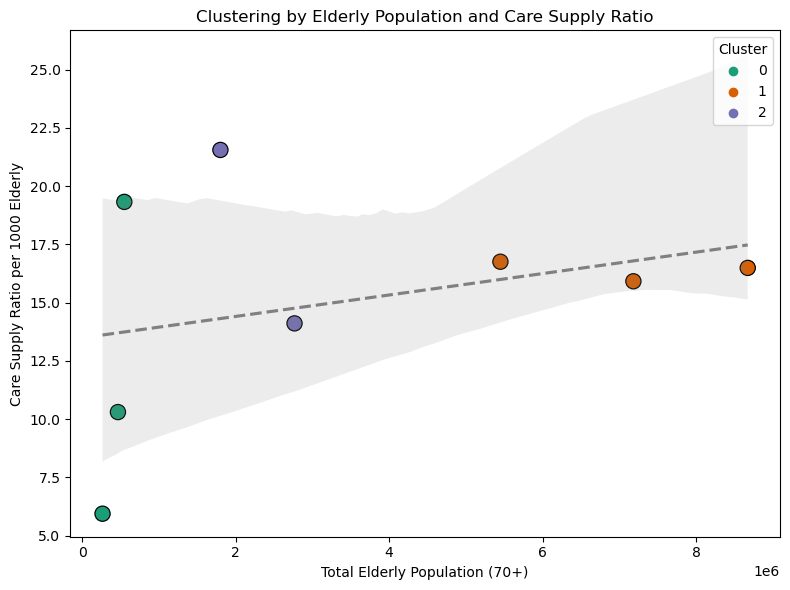

In [3]:
# Plot 2: Scatter Plot with Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Total_Elderly', y='Care_Supply_Ratio', hue='Cluster',
                data=df, palette='Dark2', s=120, edgecolor='black')
sns.regplot(x='Total_Elderly', y='Care_Supply_Ratio', data=df, scatter=False, color='grey', line_kws={"linestyle": "dashed"})
plt.title('Clustering by Elderly Population and Care Supply Ratio')
plt.xlabel('Total Elderly Population (70+)')
plt.ylabel('Care Supply Ratio per 1000 Elderly')
plt.tight_layout()
plt.show()

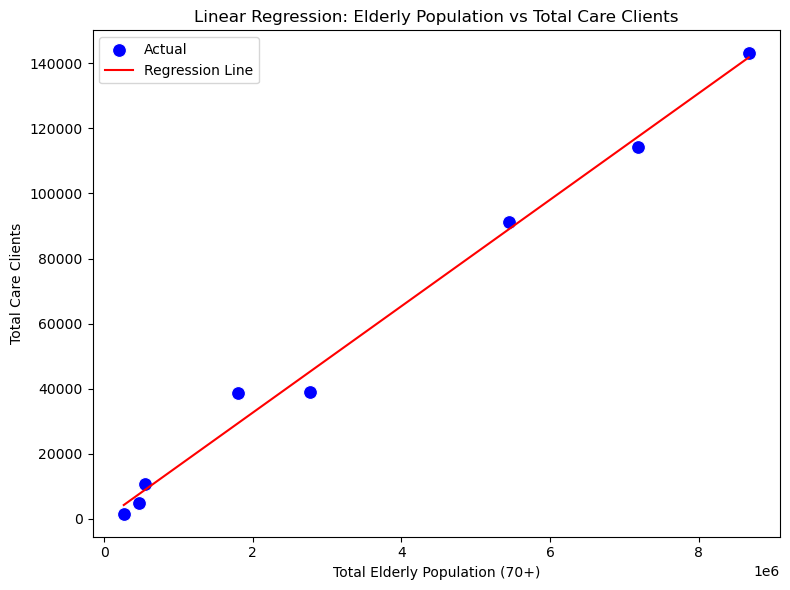

In [4]:
# Plot 3: Regression Line
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Elderly_Population', y='Target', data=df, s=100, color='blue', label='Actual')
sns.lineplot(x='Elderly_Population', y='Predicted_Care', data=df, color='red', label='Regression Line')
plt.title('Linear Regression: Elderly Population vs Total Care Clients')
plt.xlabel('Total Elderly Population (70+)')
plt.ylabel('Total Care Clients')
plt.legend()
plt.tight_layout()
plt.show()

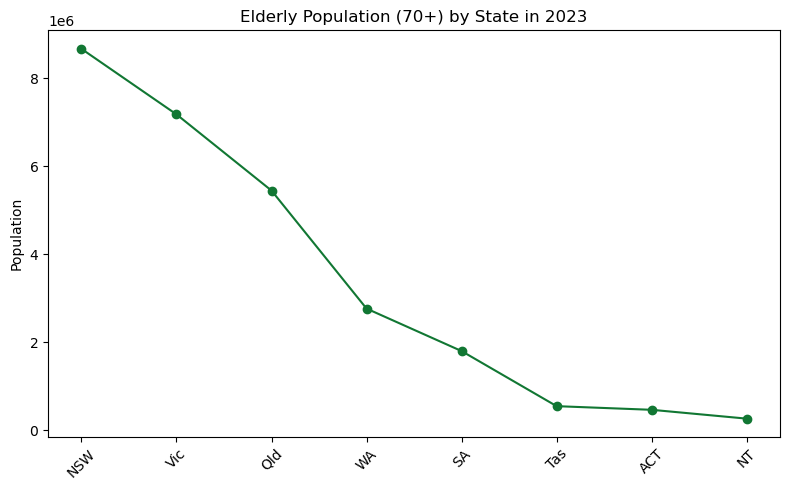

In [5]:
# Plot 4: Line Graph of Elderly Population
plt.figure(figsize=(8, 5))
df['Elderly_Population'].plot(kind='line', marker='o', color='#117733')
plt.title('Elderly Population (70+) by State in 2023')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import r2_score

r_squared = r2_score(df['Total_Care_Clients'], df['Predicted_Care'])
print(f"R-squared value for the regression model: {r_squared:.4f}")


R-squared value for the regression model: 0.9922
